# Amoeba en Borovicka

In [1]:
from scipy import optimize, stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

## Funciones

In [14]:
"""
Funciones de Borovicka que
dependen de [C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0]
"""

def construct_radio(C, A, F, X0, Y0, a0):
    def r(x, y):
        return C * ( np.sqrt( (x-X0)**2 + (y-Y0)**2 ) + A*(y-X0)*np.cos(F-a0) - A*(x-X0)*np.sin(F-a0) )
    return r

def construct_u(C, A, F, V, S, D, P, Q, X0, Y0, a0):
    def u(x, y):
        r = construct_radio(C, A, F, X0, Y0, a0)
        return V*r(x, y) + S*(np.e**(D*r(x,y)) - 1) + P*(np.e**(Q*r(x,y)**2) - 1) 
    return u

def construct_b(E, X0, Y0, a0):
    def b(x, y):
        return a0 - E + np.arctan2((y - Y0),(x - X0))
    return b

def construct_altura(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0):
    def z(x, y):
        u = construct_u(C, A, F, V, S, D, P, Q, X0, Y0, a0)
        b = construct_b(E, X0, Y0, a0)
        return np.arccos( np.cos(u(x,y))*np.cos(ep) - np.sin(u(x,y))*np.sin(ep)*np.cos(b(x,y)) )
    return z

def construct_altura_deg(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0):
    def z(x, y):
        u = construct_u(C, A, F, V, S, D, P, Q, X0, Y0, a0)
        b = construct_b(E, X0, Y0, a0)
        return 90 - np.rad2deg( np.arccos( np.cos(u(x,y))*np.cos(ep) - np.sin(u(x,y))*np.sin(ep)*np.cos(b(x,y)) ) )
    return z

def construct_azimuth(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0):
    def az(x, y):
        u = construct_u(C, A, F, V, S, D, P, Q, X0, Y0, a0)
        b = construct_b(E, X0, Y0, a0)
        z = construct_altura(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0)
        return np.arcsin( np.sin(b(x,y))*np.sin(u(x,y))/np.sin(z(x,y)) ) + E
    return az

def construct_azimuth_deg(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0):
    def az(x, y):
        u = construct_u(C, A, F, V, S, D, P, Q, X0, Y0, a0)
        b = construct_b(E, X0, Y0, a0)
        z = construct_altura(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0)
        return np.rad2deg( np.arcsin( np.sin(b(x,y))*np.sin(u(x,y))/np.sin(z(x,y)) ) + E ) + 90
    return az

"""
Estos son constructores de una funcion de Xi**2
"""

def construct_alt_xi(x, y, z):
    def xi(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0):
        alt_teorico = construct_altura_deg(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0)
        return (z - alt_teorico(x, y))**2
    return xi

def construct_az_xi(x, y, z):
    def xi(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0):
        az_teorico = construct_azimuth_deg(C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0)
        return (z - az_teorico(x, y))**2
    return xi

In [3]:
"""
Para reducir los datos outlayers segun que tan lejos quedan de la primera
aproximacion por Borovicka
"""
def drop_outlayers_by_borovicka(pixtab_df, plano, diff = 1):
    
    X_MIN = 250
    X_MAX = 1250
    Y_MIN = 0
    Y_MAX = 950
    MAX_RADIO = 500
    RADIO_STEPS = 2000
    query_str = "{}<=x<={} and {}<=y<={}".format(X_MIN, X_MAX,
                                                            Y_MIN, Y_MAX)
    data = pixtab_df.dropna(thresh = 7).query(query_str)
    
    pbar = tqdm(total=len(data.x.values), desc="Droping Outlayers")
    new_df_indx = []
    for indx in data.index:
        x = data.at[indx,"x"]
        y = data.at[indx,"y"]
        alt = data.at[indx,"alt"]
        if np.abs(plano(x,y)-alt) < diff:
            new_df_indx.append(indx)
        pbar.update()
    pbar.close()
    return data.loc[new_df_indx]

# Por si queremos exportar los datos para visualizarlos 
# out = drop_outlayers_by_borovicka(data, X0, Y0)
# out
# out["xcentroid"] = out["x"]
# out["ycentroid"] = out["y"]
# out.to_csv("drop_outlayer.dat", sep=' ', index=False)
# plt.gca().invert_yaxis()
# plt.scatter(out.x.values, out.y.values, c=out.alt.values, s=0.01)

In [4]:
"""
Para plotear la altura o el azimut, es necesaria
una lista con todos los parametros 
[C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0]
"""

def plot_plano(plano):
    x = np.linspace(0, 1200, 100)
    y = np.linspace(0, 900, 100)
    X, Y = np.meshgrid(x, y)
    Z = plano(X, Y)
    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(X, Y, Z, 10)
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title('Toda una linea que minimiza y=mx+n')
    plt.gca().invert_yaxis()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

def plot_altura(vector):
    plano = construct_altura_deg(*vector)
    plot_plano(plano)
    
def plot_azimuth(vector):
    plano = construct_azimuth_deg(*vector)
    plot_plano(plano)

In [5]:
"""
Esto lo definimos por cada intento segun los parametros constantes que
queramos dejar
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        V, S, D, P, Q, a0 = ctes
        C, A, F, E, ep, X0, Y0 = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        V, S, D, P, Q, a0 = ctes
        C, A, F, E, ep, X0, Y0 = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xii
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
    new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
    new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_alt_params, new_az_params]

## Reduction types:

There are many types as mentioned in the section 2.2.3. of the paper.
However, IRED may be zero when entering REDSKY. Then the standard
reduction type 314 is used. The most usual types are

314 - V,S,D,P,Q kept at their standard values, other constants computed

334 - P,Q kept, C=1, other computed

354 - C=1, other computed (requires stars close to horizon)

311 - as 314 but A=0, F=0 (similarly 331, 351)

310 - as 311 but also epsilon=0, E=0 (similarly 330, 350) ([V,S,D,P,Q]=ctes, [A,F,E,ep]=0, solo se busca C)

319 - as 314 but epsilon,E,A,F kept at their initial values (similarly
      339, 359) ([V,S,D,P,Q,A,F,E,ep]=ctes solo se busca C)

## Algunos parametros conocidos
C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0 :


- <sub> $Xi^2=2.206$ : [0.04884978986903654, 0.020304825896093035, 0.35248628545828664, 0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06, -0.00415889519, 0.005383738310580881, 0.0014950622892165601, 724, 472, -3*np.pi/4]

- <sub>  $Xi^2=2.154$ : [4.37875766e-02,  5.19853314e-03,  1.05416567e+00,  7.33610329e-02, -5.24112025e-02, -1.39156740e-01,  4.41635759e-03,  4.71369350e-03, 2.74820813e+00, -1.02665758e-01, 731, 506, -0.582*np.pi] 

Encontrados ahora:
- [1)](#section1) <sub> $Xi^2=2.210$ : [0.048826087003725455, -0.021142174069559417, 0.32598730818211297, 0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06, -0.00415889519, 0.08741648813678929, -0.0022711518934522366, 724, 472, np.pi/4] 

- [2)](#section2) <sub> $Xi^2=2.246$ : [0.048826087003725455, -0.021142174069559417, 0.32598730818211297, 0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06, -0.00415889519, 0.08741648813678929, -0.0022711518934522366, 724.59618727, 472.68750979, np.pi/4]

- [3)](#section3) <sub> $Xi^2_{alt}=2.228$, $Xi^2_{az}=60.30$ : [0.048826087003725455, -0.021142174069559417, 0.32598730818211297, 0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06, -0.00415889519, 0.08741648813678929, -0.0022711518934522366, 724.59618727, 472.68750979, 0.82635545]

- [4)](#section4) <sub> $Xi^2_{alt}=2.205$, $Xi^2_{az}=20.94$ : [0.048826087003725455, -0.021142174069559417, 0.32598730818211297, 0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06, -0.00415889519, -0.0298275, -0.0022711518934522366, 724, 472, 0.75060687]
    
- [5)](#section5) <sub> $Xi^2_{alt}=3.120$, $Xi^2_{az}=15.75$ : [0.048826087003725455, -0.021142174069559417, 0.32598730818211297, 0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06, -0.00415889519, -4.82552710e-03, -0.0022711518934522366, 7.28125200e+02,  4.78181845e+02, 7.73853421e-01]
  
- [6)](#section6) <sub> $Xi^2_{alt}=2.320$, $Xi^2_{az}=15.75$ : [0.04952671,  0.00310034, -1.04782185, 0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06, -0.00415889519, -4.82552710e-03, -0.0022711518934522366, 7.28125200e+02,  4.78181845e+02, 7.73853421e-01]

- [7)](#section7) <sub> $Xi^2_{alt}=2.236$, $Xi^2_{az}=15.75$ : [0.04952671,  0.00310034, -1.04782185, 9.61696411e-02, -3.11311558e+00,  8.47643783e-03,  5.83185714e-04, 7.66455100e-03, -4.82552710e-03, -0.0022711518934522366, 7.28125200e+02,  4.78181845e+02, 7.73853421e-01]
    
- [8)](#section8) <sub> $Xi^2_{alt}=2.142$, $Xi^2_{az}=15.89$ : [0.04933449,  0.00478405, -0.1298804, 9.61696411e-02, -3.11311558e+00,  8.47643783e-03,  5.83185714e-04, 7.66455100e-03, -4.82552710e-03, -0.0022711518934522366, 7.28125200e+02,  4.78181845e+02, 7.73853421e-01]
    
- [9)](#section9) <sub> $Xi^2_{alt}=2.147$, $Xi^2_{az}=15.89$ : [0.04933449,  0.00478405, -0.1298804, 9.44302225e-02, -3.90770908e+00,  6.47675936e-03,  1.99616127e-03, 5.31560995e-03, -4.82552710e-03, -0.0022711518934522366, 7.28125200e+02,  4.78181845e+02, 7.73853421e-01]


Facts:
- mover ep reduciendo azimut es super peligroso
- hay que sumarle 90 al azimuth porque borovicka lo tiene entre \[-90,90\]
- E no solo rota, si no, que tambien ensancha o agudiza el espacio que ocupan los grados
- mover E,X0,Y0,a0 juntos reduciendo azimuth es muy bueno para encontrar el centro
- mover V,S,D,P,Q no afecta al azimuth!



[Greedy](#greedy) Intentamos reducir altura y azimut al mismo tiempo,
los paramtros iniciales fueron los obtenidos en 6

[subir](#pipeline)<a id='pipeline'></a>
## Intentemos un pipeline

Solo podriamos conocer un V,S,D,P,Q aproximado dado del paper de Borovicka. Ademas sobre C,A,F podemos seguir el consejo de hacer A,F nulos, pero C tendra que ser un valor pequeño como 0.01. Para E,ep podemos hacerlos nulos. El centro X0,Y0 tendremos que aproximarlo al ojo, tener una idea, en este caso 724,472. Por ultimo el offset del azimut a0 podemos hacerlo nulo.

El principal problema es reducir los datos en un principio porque no sabemos qué es lo que estamos descartando
El paso 2-3 es bueno separarlo para hacer la reduccion mas eficientemente

Parametros iniciales:
- [0)] <sub> $Xi^2_{alt}=46.65$, $Xi^2_{az}=1629$ : [1, 0, 0, 0.003, 0.0001, 0.00001, 0, 0, 0, 0.001, 724, 472, 0]

Luego el orden que mejor nos resultó fué:
- [1)](#paso1) Reducir altura con C,A,F,E,ep usando datos discriminados (0:14:05) <sub> $Xi^2_{alt}=2.45$, $Xi^2_{az}=1610$ : [1.09634693e+00, -2.41614073e-02, -1.34571104e-02,  3.00000000e-03, 1.00000000e-04,  1.00000000e-05,  0.00000000e+00,  0.00000000e+00, -1.26627623e-02, -1.29450497e-02,  7.24000000e+02,  4.72000000e+02, 0.00000000e+00]
    
- [2)](#paso2) Reducir azimut con a0 usando datos discriminados (0:07:24) <sub> $Xi^2_{alt}=4.01$, $Xi^2_{az}=22.75$ : [1.09634693e+00, -2.41614073e-02, -1.34571104e-02,  3.00000000e-03, 1.00000000e-04,  1.00000000e-05,  0.00000000e+00,  0.00000000e+00, -1.26627623e-02, -1.29450497e-02,  7.24000000e+02,  4.72000000e+02, 7.62670898e-01]
    
- [3)](#paso3) Reducir azimut con E,X0,Y0,a0 usando datos discriminados (0:37:55) <sub> $Xi^2_{alt}=3.72$, $Xi^2_{az}=15.68$ : [1.09634693e+00, -2.41614073e-02, -1.34571104e-02,  3.00000000e-03, 1.00000000e-04,  1.00000000e-05,  0.00000000e+00,  0.00000000e+00, -6.15188130e-03, -1.29450497e-02,  7.25270199e+02,  4.80722488e+02, 7.73233632e-01]
    
- [4)](#paso4) Reducir altura con V,S,D,P,Q usando datos discriminados (1:13:10) <sub> $Xi^2_{alt}=3.29$, $Xi^2_{az}=15.67$ : [1.09634693e+00, -2.41614073e-02, -1.34571104e-02,  3.10573615e-03, -4.26049433e-04, -5.42435262e-05,  3.42303032e-02, -1.40851767e-05, -6.15188130e-03, -1.29450497e-02,  7.25270199e+02,  4.80722488e+02, 7.73233632e-01]
    
- [5)](#paso5) Reducir altura con C,A,F usando datos discriminados (0:08:59) <sub> $Xi^2_{alt}=2.32$, $Xi^2_{az}=15.76$ : [1.11600709e+00,  6.17294833e-04, -1.83051494e-02,  3.10573615e-03,-4.26049433e-04, -5.42435262e-05,  3.42303032e-02, -1.40851767e-05,-6.15188130e-03, -1.29450497e-02,  7.25270199e+02,  4.80722488e+02,7.73233632e-01]
    
Demoró como 2 horas y media y el resultado fue regular, aun asi es raro(¿malo?) empezar discriminando datos

In [6]:
results_list = []

[subir](#pipeline)<a id='paso1'></a>
### Paso 1
Primero haremos un acercamiento 314 para buscar parametros C,A,F,E,ep que nos ayuden a reducir mejor los datos outlayers

Otra opcion era buscar E,X0,Y0,a0 desde el principio sin quitar datos outlayers, el problema es que E,ep al ser 0 tienen problemas en la funcion de azimut

In [23]:
"""
314 - V, S, D, P, Q, X0, Y0, a0
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        V, S, D, P, Q, X0, Y0, a0 = ctes
        C, A, F, E, ep, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        V, S, D, P, Q, X0, Y0, a0 = ctes
        C, A, F, E, ep, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
    new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
#     new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_alt_params]

# init_params = [*result_0[:3], *result_0[8:10]]
# ctes = [*result_0[3:8],*result_0[10:]]

init_params = [1, 0, 0, 0, 0.001]
ctes = [0.003, 0.0001, 0.00001, 0, 0,
           724, 472, 0]

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
data = drop_outlayers_by_borovicka(data, construct_altura_deg(*init_params[:3], *ctes[:-3], *init_params[-2:], *ctes[-3:]), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)

pbar = tqdm(total=1100, desc="Aproximando altura y azimuth")
results_list += amoeba(init_params, mega_alt_xi, mega_az_xi)
pbar.close()
results_list[-1]

result_1 = np.array([*results_list[-1][:3], *ctes[:-3], *results_list[-1][-2:], *ctes[-3:]])
result_1



Droping Outlayers:   0%|                                                                     | 0/80771 [00:00<?, ?it/s]

Droping Outlayers:   1%|▌                                                        | 808/80771 [00:00<00:09, 8022.57it/s]

Droping Outlayers:   2%|█                                                       | 1571/80771 [00:00<00:10, 7882.15it/s]

Droping Outlayers:   3%|█▋                                                      | 2364/80771 [00:00<00:09, 7879.10it/s]

Droping Outlayers:   4%|██▏                                                     | 3179/80771 [00:00<00:09, 7942.16it/s]

Droping Outlayers:   5%|██▊                                                     | 3981/80771 [00:00<00:09, 7947.46it/s]

Droping Outlayers:   6%|███▎                                                    | 4806/80771 [00:00<00:09, 8019.32it/s]

Droping Outlayers:   7%|███▉                                                    | 5618/80771 [00:00<00:09, 8031.79it/s]

Droping Outlayers:   8%|████▍ 

Droping Outlayers:  67%|████████████████████████████████████▉                  | 54164/80771 [00:06<00:03, 7911.68it/s]

Droping Outlayers:  68%|█████████████████████████████████████▍                 | 54957/80771 [00:06<00:03, 7899.87it/s]

Droping Outlayers:  69%|█████████████████████████████████████▉                 | 55750/80771 [00:07<00:03, 7891.63it/s]

Droping Outlayers:  70%|██████████████████████████████████████▌                | 56540/80771 [00:07<00:03, 7806.99it/s]

Droping Outlayers:  71%|███████████████████████████████████████                | 57349/80771 [00:07<00:02, 7872.98it/s]

Droping Outlayers:  72%|███████████████████████████████████████▌               | 58154/80771 [00:07<00:02, 7908.17it/s]

Droping Outlayers:  73%|████████████████████████████████████████▏              | 58946/80771 [00:07<00:02, 7894.43it/s]

Droping Outlayers:  74%|████████████████████████████████████████▋              | 59751/80771 [00:07<00:02, 7922.84it/s]

Droping Outlayers:  75%|████████

Aproximando altura y azimuth:   3%|█▌                                                | 34/1100 [01:06<34:32,  1.94s/it]

Aproximando altura y azimuth:   3%|█▌                                                | 35/1100 [01:08<34:24,  1.94s/it]

Aproximando altura y azimuth:   3%|█▋                                                | 36/1100 [01:10<34:15,  1.93s/it]

Aproximando altura y azimuth:   3%|█▋                                                | 37/1100 [01:12<34:10,  1.93s/it]

Aproximando altura y azimuth:   3%|█▋                                                | 38/1100 [01:14<34:29,  1.95s/it]

Aproximando altura y azimuth:   4%|█▊                                                | 39/1100 [01:16<34:55,  1.98s/it]

Aproximando altura y azimuth:   4%|█▊                                                | 40/1100 [01:18<35:28,  2.01s/it]

Aproximando altura y azimuth:   4%|█▊                                                | 41/1100 [01:20<34:59,  1.98s/it]

Aproximando altura y azimuth:   

Aproximando altura y azimuth:   9%|████▍                                            | 101/1100 [03:15<31:19,  1.88s/it]

Aproximando altura y azimuth:   9%|████▌                                            | 102/1100 [03:17<31:15,  1.88s/it]

Aproximando altura y azimuth:   9%|████▌                                            | 103/1100 [03:18<31:17,  1.88s/it]

Aproximando altura y azimuth:   9%|████▋                                            | 104/1100 [03:20<31:15,  1.88s/it]

Aproximando altura y azimuth:  10%|████▋                                            | 105/1100 [03:22<31:14,  1.88s/it]

Aproximando altura y azimuth:  10%|████▋                                            | 106/1100 [03:24<31:13,  1.89s/it]

Aproximando altura y azimuth:  10%|████▊                                            | 107/1100 [03:26<31:13,  1.89s/it]

Aproximando altura y azimuth:  10%|████▊                                            | 108/1100 [03:28<31:53,  1.93s/it]

Aproximando altura y azimuth:  1

Aproximando altura y azimuth:  15%|███████▍                                         | 168/1100 [05:23<29:36,  1.91s/it]

Aproximando altura y azimuth:  15%|███████▌                                         | 169/1100 [05:25<29:27,  1.90s/it]

Aproximando altura y azimuth:  15%|███████▌                                         | 170/1100 [05:27<29:25,  1.90s/it]

Aproximando altura y azimuth:  16%|███████▌                                         | 171/1100 [05:29<29:21,  1.90s/it]

Aproximando altura y azimuth:  16%|███████▋                                         | 172/1100 [05:30<29:17,  1.89s/it]

Aproximando altura y azimuth:  16%|███████▋                                         | 173/1100 [05:32<29:18,  1.90s/it]

Aproximando altura y azimuth:  16%|███████▊                                         | 174/1100 [05:34<29:16,  1.90s/it]

Aproximando altura y azimuth:  16%|███████▊                                         | 175/1100 [05:36<29:21,  1.90s/it]

Aproximando altura y azimuth:  1

Aproximando altura y azimuth:  21%|██████████▍                                      | 235/1100 [07:56<35:00,  2.43s/it]

Aproximando altura y azimuth:  21%|██████████▌                                      | 236/1100 [07:58<35:05,  2.44s/it]

Aproximando altura y azimuth:  22%|██████████▌                                      | 237/1100 [08:01<34:38,  2.41s/it]

Aproximando altura y azimuth:  22%|██████████▌                                      | 238/1100 [08:03<34:20,  2.39s/it]

Aproximando altura y azimuth:  22%|██████████▋                                      | 239/1100 [08:05<33:53,  2.36s/it]

Aproximando altura y azimuth:  22%|██████████▋                                      | 240/1100 [08:07<32:11,  2.25s/it]

Aproximando altura y azimuth:  22%|██████████▋                                      | 241/1100 [08:09<30:49,  2.15s/it]

Aproximando altura y azimuth:  22%|██████████▊                                      | 242/1100 [08:11<29:44,  2.08s/it]

Aproximando altura y azimuth:  2

Aproximando altura y azimuth:  27%|█████████████▍                                   | 302/1100 [10:08<25:44,  1.93s/it]

Aproximando altura y azimuth:  28%|█████████████▍                                   | 303/1100 [10:10<25:37,  1.93s/it]

Aproximando altura y azimuth:  28%|█████████████▌                                   | 304/1100 [10:12<25:26,  1.92s/it]

Aproximando altura y azimuth:  28%|█████████████▌                                   | 305/1100 [10:14<25:21,  1.91s/it]

Aproximando altura y azimuth:  28%|█████████████▋                                   | 306/1100 [10:16<25:15,  1.91s/it]

Aproximando altura y azimuth:  28%|█████████████▋                                   | 307/1100 [10:18<25:10,  1.91s/it]

Aproximando altura y azimuth:  28%|█████████████▋                                   | 308/1100 [10:20<25:08,  1.91s/it]

Aproximando altura y azimuth:  28%|█████████████▊                                   | 309/1100 [10:22<25:07,  1.91s/it]

Aproximando altura y azimuth:  2

Aproximando altura y azimuth:  34%|████████████████▍                                | 369/1100 [12:17<23:17,  1.91s/it]

Aproximando altura y azimuth:  34%|████████████████▍                                | 370/1100 [12:19<23:10,  1.90s/it]

Aproximando altura y azimuth:  34%|████████████████▌                                | 371/1100 [12:21<23:10,  1.91s/it]

Aproximando altura y azimuth:  34%|████████████████▌                                | 372/1100 [12:23<23:13,  1.91s/it]

Aproximando altura y azimuth:  34%|████████████████▌                                | 373/1100 [12:25<23:33,  1.94s/it]

Aproximando altura y azimuth:  34%|████████████████▋                                | 374/1100 [12:27<23:55,  1.98s/it]

Aproximando altura y azimuth:  34%|████████████████▋                                | 375/1100 [12:29<23:42,  1.96s/it]

Aproximando altura y azimuth:  34%|████████████████▋                                | 376/1100 [12:31<23:34,  1.95s/it]

Aproximando altura y azimuth:  3

Optimization terminated successfully.
         Current function value: 21981.545667
         Iterations: 251
         Function evaluations: 422


Aproximando altura y azimuth:  38%|██████████████████▊                              | 422/1100 [14:05<22:38,  2.00s/it]


array([ 1.09634693e+00, -2.41614073e-02, -1.34571104e-02,  3.00000000e-03,
        1.00000000e-04,  1.00000000e-05,  0.00000000e+00,  0.00000000e+00,
       -1.26627623e-02, -1.29450497e-02,  7.24000000e+02,  4.72000000e+02,
        0.00000000e+00])

In [ ]:
temp_result_1 = np.array([ 1.09634693e+00, -2.41614073e-02, -1.34571104e-02,  3.00000000e-03,
        1.00000000e-04,  1.00000000e-05,  0.00000000e+00,  0.00000000e+00,
       -1.26627623e-02, -1.29450497e-02,  7.24000000e+02,  4.72000000e+02,
        0.00000000e+00])

[subir](#pipeline)<a id='paso3'></a>
### Paso 3
Ahora buscamos E,X0,Y0,a0 quitando datos outlayers reduciendo azimut. Como a0 esta más cerca del resultado pude que se demore menos. (19min menos y mejor resultado)

In [27]:
"""
311 - C, A, F, V, S, D, P, Q, ep, a0
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, E, ep, X0, Y0 = ctes
        a0, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, E, ep, X0, Y0 = ctes
        a0, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
#     new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
    new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_az_params]

init_params = [result_1[-1]]
ctes = [*result_1[:-1]]

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
data = drop_outlayers_by_borovicka(data, construct_altura_deg(*ctes, *init_params), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)

pbar = tqdm(total=1100, desc="Aproximando altura y azimuth")
results_list += amoeba(init_params, mega_alt_xi, mega_az_xi)
pbar.close()
results_list[-1]

result_2 = np.array([*ctes, *results_list[-1]])
result_2



Droping Outlayers:   0%|                                                                     | 0/80771 [00:00<?, ?it/s]

Droping Outlayers:   1%|▍                                                        | 653/80771 [00:00<00:12, 6482.74it/s]

Droping Outlayers:   2%|▉                                                       | 1319/80771 [00:00<00:12, 6520.89it/s]

Droping Outlayers:   2%|█▎                                                      | 1931/80771 [00:00<00:12, 6380.18it/s]

Droping Outlayers:   3%|█▋                                                      | 2482/80771 [00:00<00:12, 6077.30it/s]

Droping Outlayers:   4%|██▏                                                     | 3169/80771 [00:00<00:12, 6282.59it/s]

Droping Outlayers:   5%|██▋                                                     | 3854/80771 [00:00<00:11, 6429.44it/s]

Droping Outlayers:   6%|███▏                                                    | 4536/80771 [00:00<00:11, 6527.67it/s]

Droping Outlayers:   6%|███▌  

Droping Outlayers:  56%|██████████████████████████████▌                        | 44940/80771 [00:06<00:05, 6445.75it/s]

Droping Outlayers:  56%|███████████████████████████████                        | 45617/80771 [00:06<00:05, 6525.35it/s]

Droping Outlayers:  57%|███████████████████████████████▌                       | 46306/80771 [00:07<00:05, 6617.25it/s]

Droping Outlayers:  58%|███████████████████████████████▉                       | 46982/80771 [00:07<00:05, 6645.07it/s]

Droping Outlayers:  59%|████████████████████████████████▍                      | 47648/80771 [00:07<00:04, 6634.48it/s]

Droping Outlayers:  60%|████████████████████████████████▉                      | 48315/80771 [00:07<00:04, 6631.03it/s]

Droping Outlayers:  61%|█████████████████████████████████▎                     | 48979/80771 [00:07<00:04, 6619.37it/s]

Droping Outlayers:  61%|█████████████████████████████████▊                     | 49657/80771 [00:07<00:04, 6652.40it/s]

Droping Outlayers:  62%|████████

Aproximando altura y azimuth:   1%|▌                                               | 14/1100 [01:44<2:14:23,  7.43s/it]

Aproximando altura y azimuth:   1%|▋                                               | 15/1100 [01:51<2:13:38,  7.39s/it]

Aproximando altura y azimuth:   1%|▋                                               | 16/1100 [01:59<2:13:30,  7.39s/it]

Aproximando altura y azimuth:   2%|▋                                               | 17/1100 [02:06<2:12:47,  7.36s/it]

Aproximando altura y azimuth:   2%|▊                                               | 18/1100 [02:13<2:12:10,  7.33s/it]

Aproximando altura y azimuth:   2%|▊                                               | 19/1100 [02:21<2:12:03,  7.33s/it]

Aproximando altura y azimuth:   2%|▊                                               | 20/1100 [02:28<2:11:44,  7.32s/it]

Aproximando altura y azimuth:   2%|▉                                               | 21/1100 [02:35<2:11:31,  7.31s/it]

Aproximando altura y azimuth:   

Optimization terminated successfully.
         Current function value: 1770259.962164
         Iterations: 30
         Function evaluations: 60


Aproximando altura y azimuth:   5%|██▌                                             | 60/1100 [07:24<2:08:32,  7.42s/it]


array([ 1.09634693e+00, -2.41614073e-02, -1.34571104e-02,  3.00000000e-03,
        1.00000000e-04,  1.00000000e-05,  0.00000000e+00,  0.00000000e+00,
       -1.26627623e-02, -1.29450497e-02,  7.24000000e+02,  4.72000000e+02,
        7.62670898e-01])

In [ ]:
temp_result_2 = np.array([ 1.09634693e+00, -2.41614073e-02, -1.34571104e-02,  3.00000000e-03,
        1.00000000e-04,  1.00000000e-05,  0.00000000e+00,  0.00000000e+00,
       -1.26627623e-02, -1.29450497e-02,  7.24000000e+02,  4.72000000e+02,
        7.62670898e-01])

### Paso 3
Ahora buscamos E,X0,Y0,a0 quitando datos outlayers reduciendo azimut. Como a0 esta más cerca del resultado pude que se demore menos. (19min menos y mejor resultado)

In [29]:
"""
311 - C, A, F, V, S, D, P, Q, ep, a0
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, ep = ctes
        E, X0, Y0, a0, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, ep = ctes
        E, X0, Y0, a0, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
#     new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
    new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_az_params]

init_params = [result_2[8], *result_2[-3:]]
ctes = [*result_2[:8], result_2[9]]

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
data = drop_outlayers_by_borovicka(data, construct_altura_deg(*ctes[:-1], init_params[0], ctes[-1], *init_params[-3:]), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)

pbar = tqdm(total=1100, desc="Aproximando altura y azimuth")
results_list += amoeba(init_params, mega_alt_xi, mega_az_xi)
pbar.close()
results_list[-1]

result_3 = np.array([*ctes[:-1], results_list[-1][0], ctes[-1], *results_list[-1][-3:]])
result_3



Droping Outlayers:   0%|                                                                     | 0/80771 [00:00<?, ?it/s]

Droping Outlayers:   1%|▎                                                        | 503/80771 [00:00<00:16, 4993.51it/s]

Droping Outlayers:   1%|▊                                                       | 1183/80771 [00:00<00:14, 5416.48it/s]

Droping Outlayers:   2%|█▏                                                      | 1721/80771 [00:00<00:14, 5393.60it/s]

Droping Outlayers:   3%|█▌                                                      | 2277/80771 [00:00<00:14, 5430.84it/s]

Droping Outlayers:   3%|█▉                                                      | 2742/80771 [00:00<00:15, 5157.80it/s]

Droping Outlayers:   4%|██▏                                                     | 3217/80771 [00:00<00:15, 5016.65it/s]

Droping Outlayers:   5%|██▌                                                     | 3719/80771 [00:00<00:15, 5006.68it/s]

Droping Outlayers:   5%|██▉   

Droping Outlayers:  53%|█████████████████████████████▎                         | 43111/80771 [00:06<00:05, 6489.60it/s]

Droping Outlayers:  54%|█████████████████████████████▊                         | 43761/80771 [00:06<00:05, 6364.65it/s]

Droping Outlayers:  55%|██████████████████████████████▎                        | 44442/80771 [00:07<00:05, 6478.48it/s]

Droping Outlayers:  56%|██████████████████████████████▋                        | 45125/80771 [00:07<00:05, 6566.21it/s]

Droping Outlayers:  57%|███████████████████████████████▏                       | 45783/80771 [00:07<00:05, 6478.74it/s]

Droping Outlayers:  57%|███████████████████████████████▌                       | 46432/80771 [00:07<00:05, 6410.63it/s]

Droping Outlayers:  58%|████████████████████████████████                       | 47100/80771 [00:07<00:05, 6475.34it/s]

Droping Outlayers:  59%|████████████████████████████████▌                      | 47778/80771 [00:07<00:05, 6549.93it/s]

Droping Outlayers:  60%|████████

Aproximando altura y azimuth:   1%|▍                                               | 11/1100 [01:23<2:21:40,  7.81s/it]

Aproximando altura y azimuth:   1%|▌                                               | 12/1100 [01:30<2:18:54,  7.66s/it]

Aproximando altura y azimuth:   1%|▌                                               | 13/1100 [01:37<2:17:01,  7.56s/it]

Aproximando altura y azimuth:   1%|▌                                               | 14/1100 [01:45<2:16:23,  7.54s/it]

Aproximando altura y azimuth:   1%|▋                                               | 15/1100 [01:52<2:16:11,  7.53s/it]

Aproximando altura y azimuth:   1%|▋                                               | 16/1100 [02:00<2:16:38,  7.56s/it]

Aproximando altura y azimuth:   2%|▋                                               | 17/1100 [02:08<2:16:43,  7.57s/it]

Aproximando altura y azimuth:   2%|▊                                               | 18/1100 [02:15<2:16:38,  7.58s/it]

Aproximando altura y azimuth:   

Aproximando altura y azimuth:   7%|███▍                                            | 78/1100 [09:49<2:08:13,  7.53s/it]

Aproximando altura y azimuth:   7%|███▍                                            | 79/1100 [09:57<2:07:04,  7.47s/it]

Aproximando altura y azimuth:   7%|███▍                                            | 80/1100 [10:04<2:06:24,  7.44s/it]

Aproximando altura y azimuth:   7%|███▌                                            | 81/1100 [10:11<2:05:23,  7.38s/it]

Aproximando altura y azimuth:   7%|███▌                                            | 82/1100 [10:19<2:05:06,  7.37s/it]

Aproximando altura y azimuth:   8%|███▌                                            | 83/1100 [10:27<2:08:45,  7.60s/it]

Aproximando altura y azimuth:   8%|███▋                                            | 84/1100 [10:34<2:09:37,  7.65s/it]

Aproximando altura y azimuth:   8%|███▋                                            | 85/1100 [10:42<2:09:36,  7.66s/it]

Aproximando altura y azimuth:   

Aproximando altura y azimuth:  13%|██████▏                                        | 145/1100 [18:14<2:00:15,  7.56s/it]

Aproximando altura y azimuth:  13%|██████▏                                        | 146/1100 [18:22<2:01:59,  7.67s/it]

Aproximando altura y azimuth:  13%|██████▎                                        | 147/1100 [18:30<2:03:38,  7.78s/it]

Aproximando altura y azimuth:  13%|██████▎                                        | 148/1100 [18:38<2:01:34,  7.66s/it]

Aproximando altura y azimuth:  14%|██████▎                                        | 149/1100 [18:45<1:59:34,  7.54s/it]

Aproximando altura y azimuth:  14%|██████▍                                        | 150/1100 [18:53<2:00:22,  7.60s/it]

Aproximando altura y azimuth:  14%|██████▍                                        | 151/1100 [19:00<2:01:03,  7.65s/it]

Aproximando altura y azimuth:  14%|██████▍                                        | 152/1100 [19:08<2:01:06,  7.66s/it]

Aproximando altura y azimuth:  1

Aproximando altura y azimuth:  19%|█████████                                      | 212/1100 [26:42<1:57:45,  7.96s/it]

Aproximando altura y azimuth:  19%|█████████                                      | 213/1100 [26:49<1:55:32,  7.82s/it]

Aproximando altura y azimuth:  19%|█████████▏                                     | 214/1100 [26:57<1:53:53,  7.71s/it]

Aproximando altura y azimuth:  20%|█████████▏                                     | 215/1100 [27:04<1:54:14,  7.75s/it]

Aproximando altura y azimuth:  20%|█████████▏                                     | 216/1100 [27:12<1:54:00,  7.74s/it]

Aproximando altura y azimuth:  20%|█████████▎                                     | 217/1100 [27:20<1:53:38,  7.72s/it]

Aproximando altura y azimuth:  20%|█████████▎                                     | 218/1100 [27:27<1:52:59,  7.69s/it]

Aproximando altura y azimuth:  20%|█████████▎                                     | 219/1100 [27:35<1:53:05,  7.70s/it]

Aproximando altura y azimuth:  2

Aproximando altura y azimuth:  25%|███████████▉                                   | 279/1100 [35:14<1:42:47,  7.51s/it]

Aproximando altura y azimuth:  25%|███████████▉                                   | 280/1100 [35:22<1:42:22,  7.49s/it]

Aproximando altura y azimuth:  26%|████████████                                   | 281/1100 [35:29<1:42:46,  7.53s/it]

Aproximando altura y azimuth:  26%|████████████                                   | 282/1100 [35:37<1:43:46,  7.61s/it]

Aproximando altura y azimuth:  26%|████████████                                   | 283/1100 [35:45<1:43:23,  7.59s/it]

Aproximando altura y azimuth:  26%|████████████▏                                  | 284/1100 [35:52<1:43:24,  7.60s/it]

Aproximando altura y azimuth:  26%|████████████▏                                  | 285/1100 [36:00<1:43:58,  7.65s/it]

Aproximando altura y azimuth:  26%|████████████▏                                  | 286/1100 [36:08<1:44:07,  7.68s/it]

Aproximando altura y azimuth:  2

Optimization terminated successfully.
         Current function value: 1209865.018343
         Iterations: 173
         Function evaluations: 300


Aproximando altura y azimuth:  27%|████████████▊                                  | 300/1100 [37:55<1:41:09,  7.59s/it]


array([ 1.09634693e+00, -2.41614073e-02, -1.34571104e-02,  3.00000000e-03,
        1.00000000e-04,  1.00000000e-05,  0.00000000e+00,  0.00000000e+00,
       -6.15188130e-03, -1.29450497e-02,  7.25270199e+02,  4.80722488e+02,
        7.73233632e-01])

In [ ]:
temp_result_3 = np.array([1.09634693e+00, -2.41614073e-02, -1.34571104e-02,  3.00000000e-03,
        1.00000000e-04,  1.00000000e-05,  0.00000000e+00,  0.00000000e+00,
       -6.15188130e-03, -1.29450497e-02,  7.25270199e+02,  4.80722488e+02,
        7.73233632e-01])

[subir](#pipeline)<a id='paso4'></a>
### Paso 4
Ahora buscamos V,S,D,P,Q reduciendo la altura. Según lo que experimentamos no deberia afectar al azimut

Algo particular es que si reducimos discriminando datos apunta mal, debe ser que necesita mas datos en el horizonte

In [33]:
"""
314 - V, S, D, P, Q
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, E, ep, X0, Y0, a0 = ctes
        V, S, D, P, Q, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, E, ep, X0, Y0, a0 = ctes
        V, S, D, P, Q, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
    new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
#     new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_alt_params]


init_params = [*result_3[3:8]]
ctes = [*result_3[:3], *result_3[8:]]

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
data = drop_outlayers_by_borovicka(data, construct_altura_deg(*ctes[:3],*init_params, *ctes[3:]), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)

pbar = tqdm(total=1100, desc="Aproximando altura y azimuth")
results_list += amoeba(init_params, mega_alt_xi, mega_az_xi)
pbar.close()
results_list[-1]

result_4 = np.array([*ctes[:3],*results_list[-1], *ctes[3:]])
result_4



Droping Outlayers:   0%|                                                                     | 0/80771 [00:00<?, ?it/s]

Droping Outlayers:   1%|▍                                                        | 667/80771 [00:00<00:12, 6621.85it/s]

Droping Outlayers:   2%|▉                                                       | 1323/80771 [00:00<00:12, 6588.64it/s]

Droping Outlayers:   2%|█▍                                                      | 1995/80771 [00:00<00:11, 6613.21it/s]

Droping Outlayers:   3%|█▊                                                      | 2645/80771 [00:00<00:11, 6564.27it/s]

Droping Outlayers:   4%|██▎                                                     | 3278/80771 [00:00<00:11, 6477.62it/s]

Droping Outlayers:   5%|██▋                                                     | 3936/80771 [00:00<00:11, 6493.91it/s]

Droping Outlayers:   6%|███▏                                                    | 4586/80771 [00:00<00:11, 6481.56it/s]

Droping Outlayers:   6%|███▌  

Droping Outlayers:  55%|█████████████████████████████▉                         | 44048/80771 [00:06<00:05, 6225.72it/s]

Droping Outlayers:  55%|██████████████████████████████▍                        | 44725/80771 [00:06<00:05, 6366.41it/s]

Droping Outlayers:  56%|██████████████████████████████▉                        | 45404/80771 [00:07<00:05, 6474.30it/s]

Droping Outlayers:  57%|███████████████████████████████▎                       | 46074/80771 [00:07<00:05, 6526.41it/s]

Droping Outlayers:  58%|███████████████████████████████▊                       | 46754/80771 [00:07<00:05, 6592.10it/s]

Droping Outlayers:  59%|████████████████████████████████▎                      | 47424/80771 [00:07<00:05, 6609.79it/s]

Droping Outlayers:  60%|████████████████████████████████▊                      | 48107/80771 [00:07<00:04, 6660.07it/s]

Droping Outlayers:  60%|█████████████████████████████████▏                     | 48786/80771 [00:07<00:04, 6684.09it/s]

Droping Outlayers:  61%|████████

Aproximando altura y azimuth:   1%|▍                                               | 10/1100 [00:49<1:29:14,  4.91s/it]

Aproximando altura y azimuth:   1%|▍                                               | 11/1100 [00:54<1:28:55,  4.90s/it]

Aproximando altura y azimuth:   1%|▌                                               | 12/1100 [00:59<1:28:36,  4.89s/it]

Aproximando altura y azimuth:   1%|▌                                               | 13/1100 [01:04<1:28:26,  4.88s/it]

Aproximando altura y azimuth:   1%|▌                                               | 14/1100 [01:08<1:28:07,  4.87s/it]

Aproximando altura y azimuth:   1%|▋                                               | 15/1100 [01:13<1:28:01,  4.87s/it]

Aproximando altura y azimuth:   1%|▋                                               | 16/1100 [01:19<1:29:29,  4.95s/it]

Aproximando altura y azimuth:   2%|▋                                               | 17/1100 [01:24<1:32:18,  5.11s/it]

Aproximando altura y azimuth:   

Aproximando altura y azimuth:   7%|███▎                                            | 77/1100 [06:27<1:24:19,  4.95s/it]

Aproximando altura y azimuth:   7%|███▍                                            | 78/1100 [06:32<1:24:55,  4.99s/it]

Aproximando altura y azimuth:   7%|███▍                                            | 79/1100 [06:37<1:24:48,  4.98s/it]

Aproximando altura y azimuth:   7%|███▍                                            | 80/1100 [06:42<1:25:05,  5.00s/it]

Aproximando altura y azimuth:   7%|███▌                                            | 81/1100 [06:47<1:25:17,  5.02s/it]

Aproximando altura y azimuth:   7%|███▌                                            | 82/1100 [06:52<1:24:59,  5.01s/it]

Aproximando altura y azimuth:   8%|███▌                                            | 83/1100 [06:57<1:24:54,  5.01s/it]

Aproximando altura y azimuth:   8%|███▋                                            | 84/1100 [07:02<1:24:39,  5.00s/it]

Aproximando altura y azimuth:   

Aproximando altura y azimuth:  13%|██████▏                                        | 144/1100 [12:04<1:20:53,  5.08s/it]

Aproximando altura y azimuth:  13%|██████▏                                        | 145/1100 [12:10<1:21:28,  5.12s/it]

Aproximando altura y azimuth:  13%|██████▏                                        | 146/1100 [12:14<1:20:01,  5.03s/it]

Aproximando altura y azimuth:  13%|██████▎                                        | 147/1100 [12:19<1:19:09,  4.98s/it]

Aproximando altura y azimuth:  13%|██████▎                                        | 148/1100 [12:24<1:18:25,  4.94s/it]

Aproximando altura y azimuth:  14%|██████▎                                        | 149/1100 [12:29<1:18:43,  4.97s/it]

Aproximando altura y azimuth:  14%|██████▍                                        | 150/1100 [12:34<1:18:39,  4.97s/it]

Aproximando altura y azimuth:  14%|██████▍                                        | 151/1100 [12:39<1:18:10,  4.94s/it]

Aproximando altura y azimuth:  1

Aproximando altura y azimuth:  19%|█████████                                      | 211/1100 [17:42<1:13:14,  4.94s/it]

Aproximando altura y azimuth:  19%|█████████                                      | 212/1100 [17:47<1:12:49,  4.92s/it]

Aproximando altura y azimuth:  19%|█████████                                      | 213/1100 [17:52<1:12:36,  4.91s/it]

Aproximando altura y azimuth:  19%|█████████▏                                     | 214/1100 [17:57<1:12:34,  4.92s/it]

Aproximando altura y azimuth:  20%|█████████▏                                     | 215/1100 [18:02<1:12:43,  4.93s/it]

Aproximando altura y azimuth:  20%|█████████▏                                     | 216/1100 [18:07<1:12:18,  4.91s/it]

Aproximando altura y azimuth:  20%|█████████▎                                     | 217/1100 [18:12<1:12:18,  4.91s/it]

Aproximando altura y azimuth:  20%|█████████▎                                     | 218/1100 [18:17<1:12:02,  4.90s/it]

Aproximando altura y azimuth:  2

Aproximando altura y azimuth:  25%|███████████▉                                   | 278/1100 [23:12<1:07:37,  4.94s/it]

Aproximando altura y azimuth:  25%|███████████▉                                   | 279/1100 [23:17<1:07:18,  4.92s/it]

Aproximando altura y azimuth:  25%|███████████▉                                   | 280/1100 [23:22<1:07:14,  4.92s/it]

Aproximando altura y azimuth:  26%|████████████                                   | 281/1100 [23:27<1:06:57,  4.90s/it]

Aproximando altura y azimuth:  26%|████████████                                   | 282/1100 [23:32<1:07:33,  4.95s/it]

Aproximando altura y azimuth:  26%|████████████                                   | 283/1100 [23:37<1:07:08,  4.93s/it]

Aproximando altura y azimuth:  26%|████████████▏                                  | 284/1100 [23:42<1:07:11,  4.94s/it]

Aproximando altura y azimuth:  26%|████████████▏                                  | 285/1100 [23:46<1:06:44,  4.91s/it]

Aproximando altura y azimuth:  2

Aproximando altura y azimuth:  31%|██████████████▋                                | 345/1100 [28:48<1:01:00,  4.85s/it]

Aproximando altura y azimuth:  31%|██████████████▊                                | 346/1100 [28:52<1:01:13,  4.87s/it]

Aproximando altura y azimuth:  32%|██████████████▊                                | 347/1100 [28:58<1:02:23,  4.97s/it]

Aproximando altura y azimuth:  32%|██████████████▊                                | 348/1100 [29:03<1:01:58,  4.94s/it]

Aproximando altura y azimuth:  32%|██████████████▉                                | 349/1100 [29:07<1:01:30,  4.91s/it]

Aproximando altura y azimuth:  32%|██████████████▉                                | 350/1100 [29:12<1:01:22,  4.91s/it]

Aproximando altura y azimuth:  32%|██████████████▉                                | 351/1100 [29:17<1:01:10,  4.90s/it]

Aproximando altura y azimuth:  32%|███████████████                                | 352/1100 [29:22<1:01:35,  4.94s/it]

Aproximando altura y azimuth:  3

Aproximando altura y azimuth:  37%|█████████████████▌                             | 412/1100 [34:29<1:00:58,  5.32s/it]

Aproximando altura y azimuth:  38%|█████████████████▋                             | 413/1100 [34:34<1:00:58,  5.33s/it]

Aproximando altura y azimuth:  38%|██████████████████▍                              | 414/1100 [34:39<59:58,  5.25s/it]

Aproximando altura y azimuth:  38%|██████████████████▍                              | 415/1100 [34:44<58:33,  5.13s/it]

Aproximando altura y azimuth:  38%|██████████████████▌                              | 416/1100 [34:49<58:30,  5.13s/it]

Aproximando altura y azimuth:  38%|██████████████████▌                              | 417/1100 [34:55<59:14,  5.20s/it]

Aproximando altura y azimuth:  38%|██████████████████▌                              | 418/1100 [35:00<58:36,  5.16s/it]

Aproximando altura y azimuth:  38%|██████████████████▋                              | 419/1100 [35:05<58:10,  5.13s/it]

Aproximando altura y azimuth:  3

Aproximando altura y azimuth:  44%|█████████████████████▎                           | 479/1100 [40:08<50:59,  4.93s/it]

Aproximando altura y azimuth:  44%|█████████████████████▍                           | 480/1100 [40:13<51:07,  4.95s/it]

Aproximando altura y azimuth:  44%|█████████████████████▍                           | 481/1100 [40:18<50:57,  4.94s/it]

Aproximando altura y azimuth:  44%|█████████████████████▍                           | 482/1100 [40:23<50:55,  4.94s/it]

Aproximando altura y azimuth:  44%|█████████████████████▌                           | 483/1100 [40:28<51:45,  5.03s/it]

Aproximando altura y azimuth:  44%|█████████████████████▌                           | 484/1100 [40:33<51:38,  5.03s/it]

Aproximando altura y azimuth:  44%|█████████████████████▌                           | 485/1100 [40:38<51:11,  4.99s/it]

Aproximando altura y azimuth:  44%|█████████████████████▋                           | 486/1100 [40:43<50:48,  4.97s/it]

Aproximando altura y azimuth:  4

Aproximando altura y azimuth:  50%|████████████████████████▎                        | 546/1100 [45:46<46:24,  5.03s/it]

Aproximando altura y azimuth:  50%|████████████████████████▎                        | 547/1100 [45:51<46:03,  5.00s/it]

Aproximando altura y azimuth:  50%|████████████████████████▍                        | 548/1100 [45:57<47:15,  5.14s/it]

Aproximando altura y azimuth:  50%|████████████████████████▍                        | 549/1100 [46:02<47:45,  5.20s/it]

Aproximando altura y azimuth:  50%|████████████████████████▌                        | 550/1100 [46:07<46:46,  5.10s/it]

Aproximando altura y azimuth:  50%|████████████████████████▌                        | 551/1100 [46:12<46:11,  5.05s/it]

Aproximando altura y azimuth:  50%|████████████████████████▌                        | 552/1100 [46:17<45:48,  5.02s/it]

Aproximando altura y azimuth:  50%|████████████████████████▋                        | 553/1100 [46:22<46:49,  5.14s/it]

Aproximando altura y azimuth:  5

Aproximando altura y azimuth:  56%|███████████████████████████▎                     | 613/1100 [51:28<43:08,  5.31s/it]

Aproximando altura y azimuth:  56%|███████████████████████████▎                     | 614/1100 [51:33<42:17,  5.22s/it]

Aproximando altura y azimuth:  56%|███████████████████████████▍                     | 615/1100 [51:39<42:56,  5.31s/it]

Aproximando altura y azimuth:  56%|███████████████████████████▍                     | 616/1100 [51:44<43:10,  5.35s/it]

Aproximando altura y azimuth:  56%|███████████████████████████▍                     | 617/1100 [51:49<42:04,  5.23s/it]

Aproximando altura y azimuth:  56%|███████████████████████████▌                     | 618/1100 [51:54<41:19,  5.14s/it]

Aproximando altura y azimuth:  56%|███████████████████████████▌                     | 619/1100 [51:59<40:41,  5.08s/it]

Aproximando altura y azimuth:  56%|███████████████████████████▌                     | 620/1100 [52:04<40:12,  5.03s/it]

Aproximando altura y azimuth:  5

Aproximando altura y azimuth:  62%|██████████████████████████████▎                  | 680/1100 [57:06<34:13,  4.89s/it]

Aproximando altura y azimuth:  62%|██████████████████████████████▎                  | 681/1100 [57:11<35:15,  5.05s/it]

Aproximando altura y azimuth:  62%|██████████████████████████████▍                  | 682/1100 [57:16<35:29,  5.09s/it]

Aproximando altura y azimuth:  62%|██████████████████████████████▍                  | 683/1100 [57:21<34:57,  5.03s/it]

Aproximando altura y azimuth:  62%|██████████████████████████████▍                  | 684/1100 [57:26<34:44,  5.01s/it]

Aproximando altura y azimuth:  62%|██████████████████████████████▌                  | 685/1100 [57:31<34:51,  5.04s/it]

Aproximando altura y azimuth:  62%|██████████████████████████████▌                  | 686/1100 [57:37<35:38,  5.17s/it]

Aproximando altura y azimuth:  62%|██████████████████████████████▌                  | 687/1100 [57:42<35:24,  5.14s/it]

Aproximando altura y azimuth:  6

Aproximando altura y azimuth:  68%|███████████████████████████████▉               | 747/1100 [1:02:45<29:08,  4.95s/it]

Aproximando altura y azimuth:  68%|███████████████████████████████▉               | 748/1100 [1:02:50<29:35,  5.04s/it]

Aproximando altura y azimuth:  68%|████████████████████████████████               | 749/1100 [1:02:55<29:15,  5.00s/it]

Aproximando altura y azimuth:  68%|████████████████████████████████               | 750/1100 [1:03:00<29:00,  4.97s/it]

Aproximando altura y azimuth:  68%|████████████████████████████████               | 751/1100 [1:03:05<28:43,  4.94s/it]

Aproximando altura y azimuth:  68%|████████████████████████████████▏              | 752/1100 [1:03:10<28:49,  4.97s/it]

Aproximando altura y azimuth:  68%|████████████████████████████████▏              | 753/1100 [1:03:15<29:10,  5.04s/it]

Aproximando altura y azimuth:  69%|████████████████████████████████▏              | 754/1100 [1:03:20<29:09,  5.06s/it]

Aproximando altura y azimuth:  6

Aproximando altura y azimuth:  74%|██████████████████████████████████▊            | 814/1100 [1:08:16<23:54,  5.02s/it]

Aproximando altura y azimuth:  74%|██████████████████████████████████▊            | 815/1100 [1:08:21<23:34,  4.96s/it]

Aproximando altura y azimuth:  74%|██████████████████████████████████▊            | 816/1100 [1:08:26<23:32,  4.97s/it]

Aproximando altura y azimuth:  74%|██████████████████████████████████▉            | 817/1100 [1:08:31<23:35,  5.00s/it]

Aproximando altura y azimuth:  74%|██████████████████████████████████▉            | 818/1100 [1:08:36<23:32,  5.01s/it]

Aproximando altura y azimuth:  74%|██████████████████████████████████▉            | 819/1100 [1:08:41<23:27,  5.01s/it]

Aproximando altura y azimuth:  75%|███████████████████████████████████            | 820/1100 [1:08:46<23:20,  5.00s/it]

Aproximando altura y azimuth:  75%|███████████████████████████████████            | 821/1100 [1:08:51<23:04,  4.96s/it]

Aproximando altura y azimuth:  7

Optimization terminated successfully.
         Current function value: 106805.370604
         Iterations: 521
         Function evaluations: 873


Aproximando altura y azimuth:  79%|█████████████████████████████████████▎         | 873/1100 [1:13:10<19:01,  5.03s/it]


array([ 1.09634693e+00, -2.41614073e-02, -1.34571104e-02,  3.10573615e-03,
       -4.26049433e-04, -5.42435262e-05,  3.42303032e-02, -1.40851767e-05,
       -6.15188130e-03, -1.29450497e-02,  7.25270199e+02,  4.80722488e+02,
        7.73233632e-01])

In [ ]:
temp_result_4 = np.array([ 1.09634693e+00, -2.41614073e-02, -1.34571104e-02,  3.10573615e-03,
       -4.26049433e-04, -5.42435262e-05,  3.42303032e-02, -1.40851767e-05,
       -6.15188130e-03, -1.29450497e-02,  7.25270199e+02,  4.80722488e+02,
        7.73233632e-01])

[subir](#pipeline)<a id='paso5'></a>
## Paso 5
Ahora buscamos C,A,F reduciendo la altura. Según lo que experimentamos no deberia afectar al azimut

In [36]:
"""
314 - V, S, D, P, Q, X0, Y0, a0
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        V, S, D, P, Q, E, ep, X0, Y0, a0 = ctes
        C, A, F, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        V, S, D, P, Q, E, ep, X0, Y0, a0 = ctes
        C, A, F, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
    new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
#     new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_alt_params]

init_params = [*result_4[:3]]
ctes = [*result_4[3:]]

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
data = drop_outlayers_by_borovicka(data, construct_altura_deg(*init_params, *ctes), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)

pbar = tqdm(total=1100, desc="Aproximando altura y azimuth")
results_list += amoeba(init_params, mega_alt_xi, mega_az_xi)
pbar.close()
results_list[-1]

result_5 = np.array([*results_list[-1], *ctes])
result_5



Droping Outlayers:   0%|                                                                     | 0/80771 [00:00<?, ?it/s]

Droping Outlayers:   1%|▍                                                        | 669/80771 [00:00<00:12, 6641.41it/s]

Droping Outlayers:   2%|▉                                                       | 1330/80771 [00:00<00:12, 6617.40it/s]

Droping Outlayers:   2%|█▍                                                      | 1985/80771 [00:00<00:11, 6582.50it/s]

Droping Outlayers:   3%|█▊                                                      | 2650/80771 [00:00<00:11, 6588.28it/s]

Droping Outlayers:   4%|██▎                                                     | 3326/80771 [00:00<00:11, 6624.61it/s]

Droping Outlayers:   5%|██▋                                                     | 3933/80771 [00:00<00:11, 6432.87it/s]

Droping Outlayers:   6%|███▏                                                    | 4594/80771 [00:00<00:11, 6470.62it/s]

Droping Outlayers:   6%|███▌  

Droping Outlayers:  54%|█████████████████████████████▋                         | 43645/80771 [00:06<00:05, 6547.50it/s]

Droping Outlayers:  55%|██████████████████████████████▏                        | 44317/80771 [00:06<00:05, 6583.26it/s]

Droping Outlayers:  56%|██████████████████████████████▋                        | 44977/80771 [00:07<00:05, 6554.67it/s]

Droping Outlayers:  56%|███████████████████████████████                        | 45634/80771 [00:07<00:05, 6411.74it/s]

Droping Outlayers:  57%|███████████████████████████████▌                       | 46277/80771 [00:07<00:05, 6346.47it/s]

Droping Outlayers:  58%|███████████████████████████████▉                       | 46944/80771 [00:07<00:05, 6426.19it/s]

Droping Outlayers:  59%|████████████████████████████████▍                      | 47588/80771 [00:07<00:05, 6303.93it/s]

Droping Outlayers:  60%|████████████████████████████████▊                      | 48220/80771 [00:07<00:05, 6148.38it/s]

Droping Outlayers:  61%|████████

Aproximando altura y azimuth:   1%|▍                                               | 10/1100 [00:49<1:29:45,  4.94s/it]

Aproximando altura y azimuth:   1%|▍                                               | 11/1100 [00:54<1:29:13,  4.92s/it]

Aproximando altura y azimuth:   1%|▌                                               | 12/1100 [00:59<1:28:18,  4.87s/it]

Aproximando altura y azimuth:   1%|▌                                               | 13/1100 [01:04<1:27:56,  4.85s/it]

Aproximando altura y azimuth:   1%|▌                                               | 14/1100 [01:08<1:27:28,  4.83s/it]

Aproximando altura y azimuth:   1%|▋                                               | 15/1100 [01:13<1:27:12,  4.82s/it]

Aproximando altura y azimuth:   1%|▋                                               | 16/1100 [01:18<1:26:47,  4.80s/it]

Aproximando altura y azimuth:   2%|▋                                               | 17/1100 [01:23<1:26:59,  4.82s/it]

Aproximando altura y azimuth:   

Aproximando altura y azimuth:   7%|███▎                                            | 77/1100 [06:15<1:22:15,  4.82s/it]

Aproximando altura y azimuth:   7%|███▍                                            | 78/1100 [06:19<1:22:11,  4.83s/it]

Aproximando altura y azimuth:   7%|███▍                                            | 79/1100 [06:24<1:22:04,  4.82s/it]

Aproximando altura y azimuth:   7%|███▍                                            | 80/1100 [06:29<1:21:46,  4.81s/it]

Aproximando altura y azimuth:   7%|███▌                                            | 81/1100 [06:34<1:21:30,  4.80s/it]

Aproximando altura y azimuth:   7%|███▌                                            | 82/1100 [06:39<1:23:10,  4.90s/it]

Aproximando altura y azimuth:   8%|███▌                                            | 83/1100 [06:44<1:22:37,  4.87s/it]

Aproximando altura y azimuth:   8%|███▋                                            | 84/1100 [06:49<1:22:04,  4.85s/it]

Aproximando altura y azimuth:   

Optimization terminated successfully.
         Current function value: 39379.823120
         Iterations: 58
         Function evaluations: 111


Aproximando altura y azimuth:  10%|████▋                                          | 111/1100 [08:59<1:20:05,  4.86s/it]


array([ 1.11600709e+00,  6.17294833e-04, -1.83051494e-02,  3.10573615e-03,
       -4.26049433e-04, -5.42435262e-05,  3.42303032e-02, -1.40851767e-05,
       -6.15188130e-03, -1.29450497e-02,  7.25270199e+02,  4.80722488e+02,
        7.73233632e-01])

In [ ]:
temp_result_5 = np.array([ 1.11600709e+00,  6.17294833e-04, -1.83051494e-02,  3.10573615e-03,
       -4.26049433e-04, -5.42435262e-05,  3.42303032e-02, -1.40851767e-05,
       -6.15188130e-03, -1.29450497e-02,  7.25270199e+02,  4.80722488e+02,
        7.73233632e-01])

# Desarrollo

In [ ]:
"""
314 - V, S, D, P, Q, X0, Y0, a0
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        V, S, D, P, Q, X0, Y0, a0 = ctes
        C, A, F, E, ep, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        V, S, D, P, Q, X0, Y0, a0 = ctes
        C, A, F, E, ep, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
    new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
#     new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_alt_params]

In [ ]:
init_params = [0.01, 0, 0, 0, 0]
ctes = [0.03, 0.007, 0.09, 2.2*10**-6, 0.006,
           724, 472, 0]

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
data = drop_outlayers_by_borovicka(data, construct_altura_deg(*init_params[:3], *ctes[:-3], *init_params[-2:], *ctes[-3:]), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)
results_list = []

In [ ]:
pbar = tqdm(total=2200, desc="Aproximando altura y azimuth")
results_list += amoeba(init_params, mega_alt_xi, mega_az_xi)
pbar.close()
results_list[-1]

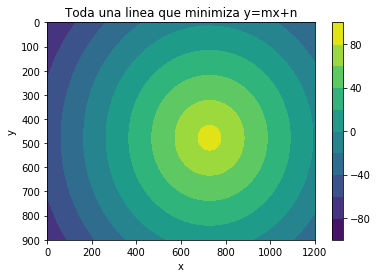

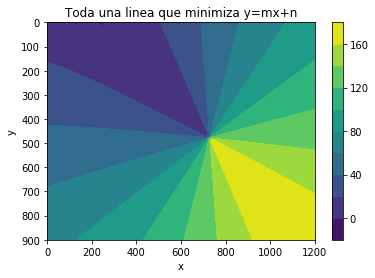

In [38]:
# result_3 = (0.09935315, -0.03387904, -0.04467695,
#              0.03, 0.007, 0.09, 2.2*10**-6, 0.006,
#             0.01311418, -0.00192129, 724, 472, 0)
plot_altura(result_5)
plot_azimuth(result_5)

In [ ]:
data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
# data = drop_outlayers_by_borovicka(data, construct_altura_deg(*init_params[:3], *ctes[:-3], *init_params[-2:], *ctes[-3:]), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)

old_params = np.array([0.01, 0, 0, 0, 0])
new_params = np.array([0.09935315, -0.03387904, -0.04467695,  0.01311418, -0.00192129])
(mega_alt_xi(old_params)/len(x_exp), mega_alt_xi(new_params)/len(x_exp))

In [ ]:
plt.gca().invert_yaxis()
plt.scatter(x_exp, y_exp, c=alt_catalogo, s=0.01)

In [ ]:
data

In [ ]:
"""
311 - C, A, F, V, S, D, P, Q, ep, a0
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, ep = ctes
        E, X0, Y0, a0, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, ep = ctes
        E, X0, Y0, a0, = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

######################################################################################################

def amoeba(params, mega_alt_xi, mega_az_xi):
#     new_alt_params = optimize.fmin(mega_alt_xi, params, maxfun=1100)
    new_az_params = optimize.fmin(mega_az_xi, params, maxfun=1100)
    return [new_az_params]

In [ ]:
init_params = [0, 724, 472, 0]
ctes = [0.01, 0, 0,
         0.03, 0.007, 0.09, 2.2*10**-6, 0.006,
         0]

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
# data = drop_outlayers_by_borovicka(data, construct_altura_deg(*ctes[:-1], init_params[0], ctes[-1], *init_params[-3:]), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo, ctes)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo, ctes)
results_list = []

In [ ]:
pbar = tqdm(total=1100, desc="Aproximando altura y azimuth")
results_list += amoeba(init_params, mega_alt_xi, mega_az_xi)
pbar.close()
results_list[-1]

In [ ]:
result_5 = (0.048826087003725455, -0.021142174069559417, 0.32598730818211297,
             0.0682171007, 0.00310608468, -5.75141386e-05, 4.26865327e-06,
             -0.00415889519, -4.82552710e-03, -0.0022711518934522366, 7.28125200e+02,  4.78181845e+02, 7.73853421e-01)
plot_altura(result_5)
plot_azimuth(result_5)

In [37]:
"""
314 - V, S, D, P, Q, X0, Y0, a0
"""

def construct_acumulate_alt_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0 = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_alt_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

def construct_acumulate_az_xi(x_list, y_list, z_list, ctes = None):
    def acumulate_xi(params):
        C, A, F, V, S, D, P, Q, E, ep, X0, Y0, a0 = params
        suma_xi = 0
        for x, y, z in zip(x_list, y_list, z_list):
            xi = construct_az_xi(int(x), int(y), int(z))
            suma_xi += xi(C, A, F, V, S, D, P, Q, E, ep, float(X0), float(Y0), a0)
        pbar.update()
        return suma_xi
    return acumulate_xi

data = pd.read_csv("Data.pixtab", sep=" ")
data = data.dropna()
# data = drop_outlayers_by_borovicka(data, construct_altura_deg(*ctes[:3],*init_params, *ctes[3:]), 5)
x_exp = data.x.values
y_exp = data.y.values
alt_catalogo = data.alt.values
az_catalogo = np.rad2deg(np.arccos(np.cos(np.deg2rad(data.az.values))))
mega_alt_xi = construct_acumulate_alt_xi(x_exp, y_exp, alt_catalogo)
mega_az_xi = construct_acumulate_az_xi(x_exp, y_exp, az_catalogo)

print("alt: ",mega_alt_xi(result_4)/len(x_exp), mega_alt_xi(result_5)/len(x_exp))
print("az: ",mega_az_xi(result_4)/len(x_exp), mega_az_xi(result_5)/len(x_exp))

alt:  3.2959843395633386 2.3236990768906898
az:  15.679366859840636 15.768853920999451
